# Visualize Urban Heat Islands (UHI) in Toulouse - France

#### <br> Data from meteo stations can be downloaded on the French open source portal https://www.data.gouv.fr/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import string
from glob import glob
from matplotlib.dates import DateFormatter
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles
from ipywidgets import Layout

In [2]:
met_files_folder = 'station-meteo' # Folder where to put meteo data files
legend_file = 'stations-meteo-en-place.csv' # File listing all meteo stations
start_date = '2019-06-27'
end_date = '2019-06-27'
toulouse_center = (43.60426, 1.44367)
default_zoom = 12

#### <br> Parse file listing all met stations 

In [3]:
leg = pd.read_csv(legend_file, sep=';')

def get_legend(id):
    return leg.loc[leg['FID']==id]['Nom_Station'].values[0]

def get_lon(id):
    return leg.loc[leg['FID']==id]['x'].values[0]

def get_lat(id):
    return leg.loc[leg['FID']==id]['y'].values[0]

#### <br> Build a Pandas dataframe from a met file

In [4]:
def get_table(file):
    df = pd.read_csv(file, sep=';')
    df.columns = list(string.ascii_lowercase)[:17]
    df['id'] = df['b']
    df['annee'] = df['e'] + 2019
    df['heure'] = (df['f'] - 1) * 15 // 60
    df['minute'] = 1 + (df['f'] - 1) * 15 % 60
    df = df.loc[df['g'] > 0] # temperature field null
    df['temperature'] = df['g'] - 50 + df['h'] / 10
    df['pluie'] = df['j'] * 0.2 # auget to mm
    df['vent_dir'] = df['k'] * 2
    df['vent_force'] = df['l'] # en dessous de 80 pareil au dessus / 2 ?
    df['pression'] = df['m'] + 900
    df['vent_max_dir'] = df['n'] * 22.5
    df['vent_max_force'] = df['o'] # en dessous de 80 pareil au dessus / 2 ?
    df['pluie_plus_intense'] = df['p'] * 0.2
    df['date'] = df['annee'].map(str) + '-' + df['c'].map(str) + '-' + df['d'].map(str) \
    + ':' + df['heure'].map(str) + '-' + df['minute'].map(str)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d:%H-%M')
    df = df[['date','id','temperature','pression','pluie','pluie_plus_intense','vent_dir', \
            'vent_force','vent_max_dir','vent_max_force']]
    df.set_index('date', inplace=True)
    df = df.loc[start_date:end_date]
    return df

#### <br> Parse met files (in met_files_folder)

In [5]:
table_list = []
for file in glob(met_files_folder + '/*.csv'):
    table_list.append(get_table(file))
tables = [table for table in table_list if not table.empty]
legs = [get_legend(table['id'].iloc[0]) for table in tables]
lats = [get_lat(table['id'].iloc[0]) for table in tables]
longs = [get_lon(table['id'].iloc[0]) for table in tables]
print('Number of meteo stations with available recordings for this time period: {}'.format(len(legs)))
print(legs)

Number of meteo stations with available recordings for this time period: 21
['Nakache', 'Toulouse_Cote_Pavee', 'Toulouse_Paul_Sabatier', 'Toulouse_Carmes', 'Toulouse_parc_japonais', 'Basso_Cambo', 'Toulouse_Lardenne', 'Marengo', 'Montaudran', 'Busca', 'La_Salade', 'Pech_David', 'Avenue_Grde_Bretagne', 'Soupetard', 'Toulouse_parc_Jardin_Plantes', 'Meteopole', 'Toulouse_Cyprien', 'Castelginest', 'Toulouse_Canceropole', 'Valade', 'Colomiers_ZA_Perget']


#### <br> Plot all met stations around Toulouse

In [6]:
m = Map(center=toulouse_center, zoom=default_zoom, layout=Layout(width='100%', height='500px'))
for i in range(len(legs)):
    m.add_layer(Marker(location=(lats[i], longs[i]), draggable=False, title=legs[i]))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

#### <br> Plot temperature chart for all met stations

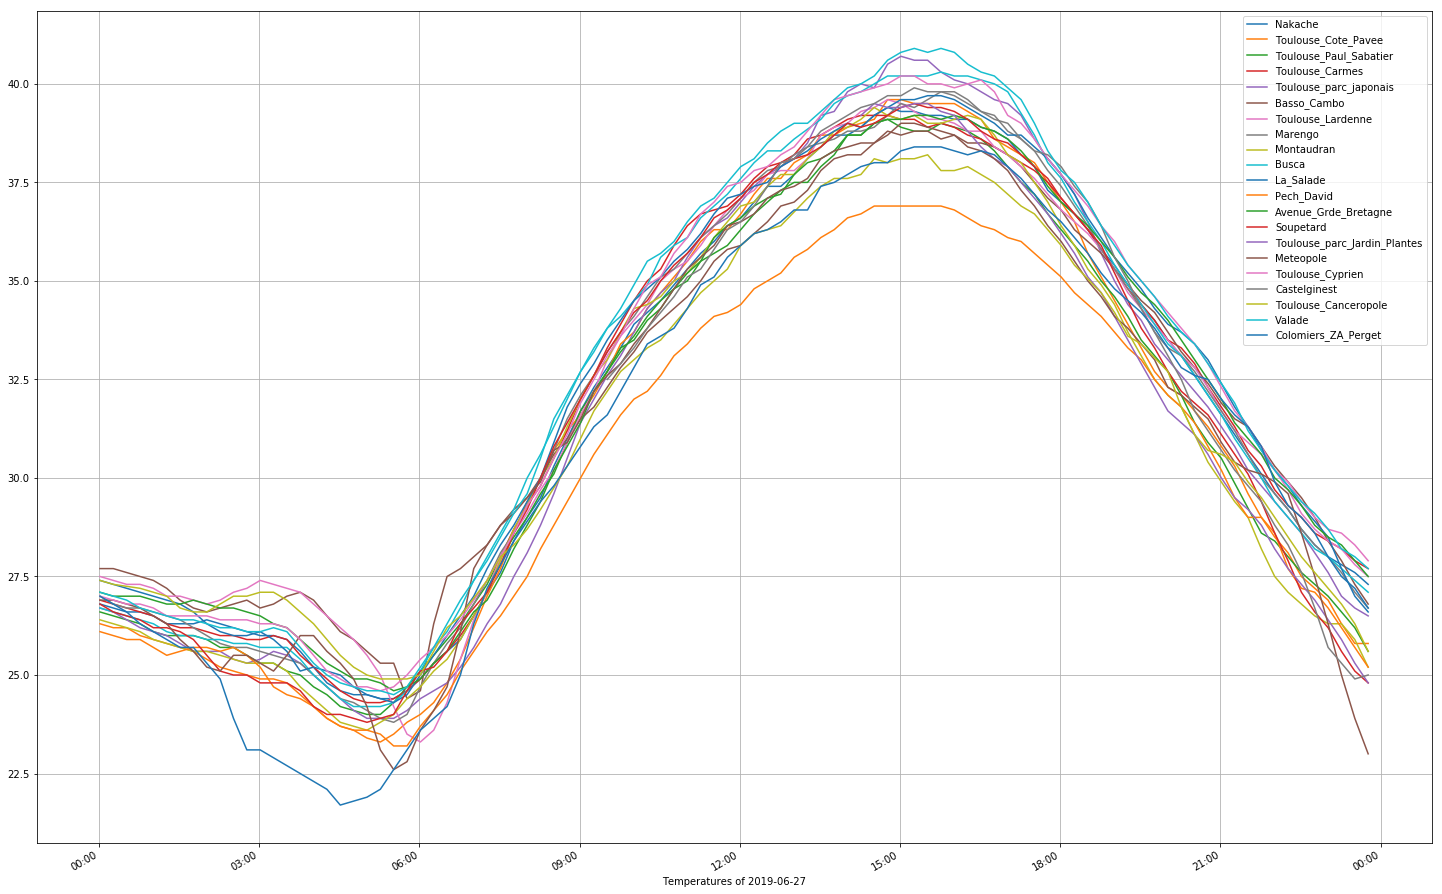

In [7]:
ax = tables[0]['temperature'].plot(grid=True, figsize=[25,17])
for i in range(1, len(tables)):
    tables[i]['temperature'].plot(grid=True, ax=ax)
ax.legend(legs)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
ax.set_xlabel('Temperatures of ' + start_date)
plt.savefig('temperatures.png')